# CaspoFlux

*Python3* notebook inferring the regulation rules of the *Case Study* regulated metabolic network from $6$ simulations.

***Warning:*** Simulation files must have been generated to run this notebook. Please run the notebook *FlexFlux-Simulations* before playing this notebook.

**Requirements:** Python 3 and the modules: bonesis, clingo, libsbml, networkX, pandas, numpy, biolqm.

## Parameters

Import the needed *Python* modules:

In [1]:
import bonesis
import clingo
from libsbml import SBMLReader
import networkx as nx
import pandas as pd
import numpy as np
import biolqm
from glob import glob
from bonesis.asp_encoding import clingo_encode

This notebook has been executed using the docker image `colomoto/colomoto-docker:2021-02-01`

## Regulated Metabolic Network

Choose the regulated metabolic network whose regulation rules must be inferred:

In [2]:
model = 'CaseStudy'

### Metabolic network

Load the *sbml* file describing the metabolic network:

In [3]:
sbmld = SBMLReader().readSBML(f'./data/{model}/metabolic_network.xml')
sbmlm = sbmld.getModel()

Extract informations: the reactions and the metabolites (internal and external).

In [4]:
reactants = set()
products = set()
reactions = set()
for reaction in sbmlm.getListOfReactions():
    name = reaction.getId()
    reactions.add(name)
    reactants.update([a.getSpecies() for a in reaction.getListOfReactants()])
    products.update([a.getSpecies() for a in reaction.getListOfProducts()])
    assert not reaction.getListOfModifiers(), 'Not implemented'
reactions

{'Growth', 'R6', 'R7', 'Rres', 'Tc1', 'Tc2', 'Td', 'Te', 'To2'}

In [5]:
inputs = reactants.difference(products)
inputs

{'Carbon1', 'Carbon2', 'Oxygen'}

In [6]:
outputs = products.difference(reactants)
outputs

{'Biomass', 'Dext', 'Eext'}

### Regulatory functions

#### Ground truth

Load the ground truth model:

In [7]:
lqm = biolqm.load(f'./data/{model}/regulatory_network.sbml')
bn = biolqm.to_minibn(lqm)
bn

Carbon1 <- 0
Oxygen <- 0
RPO2 <- !Oxygen
RPcl <- Carbon1
Rres <- !RPO2
Tc2 <- !RPcl

#### Domain of putative regulatory functions

Select the domain of putative regulatory functions, *i.e.* the solution space.

# computing graph layout...


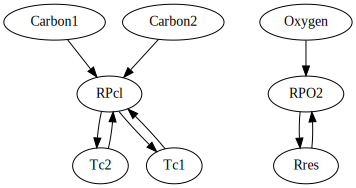

In [8]:
pkn = nx.DiGraph()
with open(f'./data/{model}/interactions.txt') as fp:
    for line in fp:
        line = line.strip()
        if not line:
            continue
        a, b = line.split()
        if b not in inputs:
            pkn.add_edge(a, b, sign=0)
        if a not in inputs:
            pkn.add_edge(b, a, sign=0)
pkn

In [9]:
dom = bonesis.InfluenceGraph(pkn, allow_skipping_nodes=True)

Extract the set of regulatory proteins:

In [10]:
regulators = set(pkn).difference(reactions).difference(inputs)
regulators

{'RPO2', 'RPcl'}

## Boolean metabolic steady states

### ASP model modeling boolean metabolic steady states

Define the metabolic network into the ASP model:

In [11]:
%%capture
metabo_asp = []
for reaction in sbmlm.getListOfReactions():
    name = reaction.getName()
    for a in reaction.getListOfReactants():
        a = a.getSpecies()
        metabo_asp.append(f'reactant("{a}","{name}").')
    for a in reaction.getListOfProducts():
        a = a.getSpecies()
        metabo_asp.append(f'product("{a}","{name}").')
    assert not reaction.getListOfModifiers(), 'Not implemented'
metabo_asp = '\n'.join(metabo_asp)

Define the quasi-steady states constraints in the ASP model:

In [12]:
mss_asp = """
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% DATA PRE-PROCESSING
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

inp(X,R) :- reactant(X,R), not product(X,_).
r(r,A,R) :- reactant(A,R), product(A,_).
r(p,A,R) :- product(A,R), reactant(A,_).

varm(A) :- r(_,A,_).
varm(A) :- r(_,_,A).
varm(A) :- inp(A,_).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% DEFINITION OF THE METABOLIC STEADY STATE
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Define the nodes possible states.
1 { v(T,A,(1;-1)) } 1 :- time(T), varm(A).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% METABOLIC STEADY STATE
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Nodes states must follow the observations.
:- obs(T,A,V), v(T,A,-V).

% A metabolite is produced/consummed by at least one reaction.
:- time(T), r(S,A,_), v(T,A,1), v(T,R,-1): r(S,A,R).

% A reaction enable its reactants and products.
:- time(T), r(_,A,R), v(T,R,1), v(T,A,-1).

% An import reaction must have all its reactants in the cell environment.
:- time(T), inp(X,R), v(T,X,-1), v(T,R,1).
"""

Instantiate the ASP model with *clingo*:

In [13]:
mss = clingo.Control(['--project', '0'])
mss.add('base', [], metabo_asp)
mss.add('base', [], mss_asp)
mss.add('base', [], 'time(t).')
mss.add('base', [], '#show v/3.')
mss.ground([('base', [])])

### List of Boolean metabolic steady states

There are $38$ Boolean metabolic steady state compatible with the *Case Study* metabolic network. These Boolean metabolic networks are shown in the table below. 

In [14]:
rows = []
for s in mss.solve(yield_=True):
    atoms = s.symbols(shown=True)
    row = {a.arguments[1].string: 0 if a.arguments[2].number < 0 else 1 for a in atoms}
    rows.append(row)
mvars = list(sorted(set(rows[0].keys()).difference(inputs)))
cols = list(sorted(inputs)) + list(sorted(reactions))
pd.DataFrame(rows, columns=cols).sort_values(cols, ignore_index=True)

,Carbon1,Carbon2,Oxygen,Growth,R6,R7,Rres,Tc1,Tc2,Td,Te,To2
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0
3,0,1,0,1,1,1,0,0,1,1,1,0
4,0,1,1,0,0,0,0,0,0,0,0,0
5,0,1,1,1,0,0,1,0,1,0,0,1
6,0,1,1,1,0,1,1,0,1,0,1,1
7,0,1,1,1,1,0,1,0,1,1,0,1
8,0,1,1,1,1,1,0,0,1,1,1,0
9,0,1,1,1,1,1,1,0,1,1,1,1


## Simulations processing

### Simulations

***Warning:*** The simulations files must have been generate with the notebook *FlexFlux-Simulations*.

Import the simulations of the *Case Study* regulated metabolic network for the $6$ experiments to the notebook.

In [15]:
cols = list(sorted(inputs)) + list(sorted(reactions)) + list(sorted(regulators))
def read_simulation(csvfile):
    df = pd.read_csv(csvfile, sep='\t', usecols=['Time'] + cols)
    df['Time'] = (df['Time']*100).astype(int)
    df.set_index('Time', inplace=True)
    return df

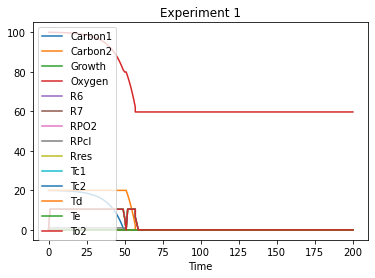

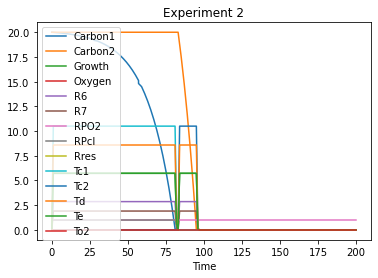

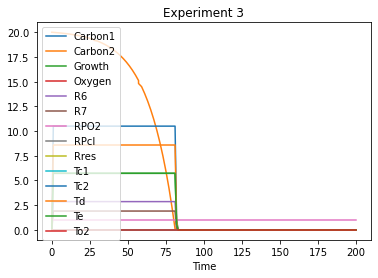

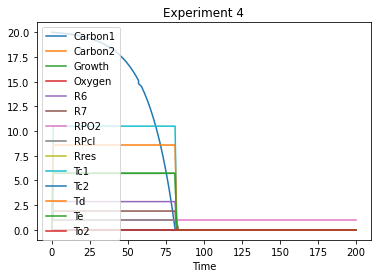

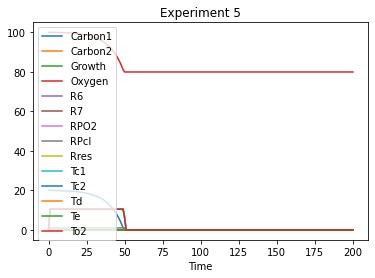

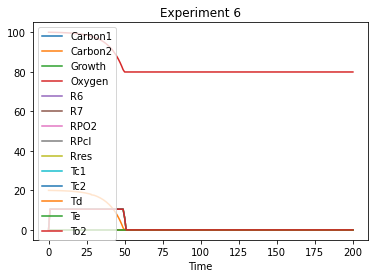

In [16]:
simfiles = glob(f'./simulations/{model}/Experiment*.csv')
simulations = {i+1: read_simulation(f) for i, f in enumerate(sorted(simfiles))}

# Display the simulations
for i, df in simulations.items():
    df.plot(title=f'Experiment {i}')

Transform each simulation's time step $t$ such that the quantity of external metabolites are the quantity after the time step $t-1$ rather than after the time step $t$. In fact, at a time step $t$, the quantity of external metabolites before the simulation of time $t$ must be known to allow computing the Boolean metabolic steady state admissible by the metabolic network at $t$. 

In [17]:
%%capture
for i, df in simulations.items():
    init = df[list(inputs)].iloc[0]
    df.loc[1:,list(inputs)] = df[list(inputs)].shift(1).loc[1:,list(inputs)]

### Binarization

Binarize each simulation's time step and filter the redundant time step. A binarized time step $t$ is consider redundant if it is identical to the binarized time step $t-1$.

Set of usefull functions.

In [18]:
def drop_repeats(df):
    return df.loc[(df.shift() != df).any(1)]

def bin_normalized_threshold(df):
    threshold = 0
    df = df/df.max() # normalization
    db = (df > threshold).astype(int) # binarize
    return drop_repeats(db)

Binarized and filtered time steps for each simulation.

In [19]:
df = pd.concat({k: bin_normalized_threshold(df) for k, df in simulations.items()})
df

Carbon1  Carbon2  Growth  Oxygen  R6  R7  RPO2  RPcl  Rres  Tc1  Tc2  \
  Time                                                                         
1 0           1        1       0       1   0   0     0     1     0    0    0   
  1           1        1       1       1   0   0     0     1     1    1    0   
  51          0        1       0       1   0   0     0     0     0    0    0   
  52          0        1       1       1   0   0     0     0     1    0    1   
  59          0        0       0       1   0   0     0     0     0    0    0   
2 0           1        1       0       0   0   0     1     1     0    0    0   
  1           1        1       1       0   1   1     1     1     0    1    0   
  83          0        1       0       0   0   0     1     0     0    0    0   
  84          0        1       1       0   1   1     1     0     0    0    1   
  97          0        0       0       0   0   0     1     0     0    0    0   
3 0           0        1       0       0   0   0     1     0     0    0    0   
  1           0        1       1       0   1   1     1     0     0    0    1   
  83          0        0       0       0   0   0     1     0     0    0    0   
4 0           1        0       0       0   0   0     1     1     0    0    0   
  1           1        0       1       0   1   1     1     1     0    1    0   
  83          0        0       0       0   0   0     1     0     0    0    0   
5 0           1        0       0       1   0   0     0     1     0    0    0   
  1           1        0       1       1   0   0     0     1     1    1    0   
  51          0        0       0       1   0   0     0     0     0    0    0   
6 0           0        1       0       1   0   0     0     0     0    0    0   
  1           0        1       1       1   0   0     0     0     1    0    1   
  51          0        0       0       1   0   0     0     0     0    0    0   

        Td  Te  To2  
  Time               
1 0      0   0    0  
  1      0   0    1  
  51     0   0    0  
  52     0   0    1  
  59     0   0    0  
2 0      0   0    0  
  1      1   1    0  
  83     0   0    0  
  84     1   1    0  
  97     0   0    0  
3 0      0   0    0  
  1      1   1    0  
  83     0   0    0  
4 0      0   0    0  
  1      1   1    0  
  83     0   0    0  
5 0      0   0    0  
  1      0   0    1  
  51     0   0    0  
6 0      0   0    0  
  1      0   0    1  
  51     0   0    0

#### Verification of dataset (Optional)

The dataset composed of binarized time steps can be checked to ensure that there is not error in the input data.

In [20]:
def check_mss(row):
    mss = clingo.Control()
    mss.add('base', [], metabo_asp+mss_asp+'time(t).')
    for n, v in row.items():
        if not isinstance(v, int) and not v.is_integer():
            continue
        v = int(v*2-1)
        n = clingo_encode(n)
        v = clingo_encode(v)
        cst = clingo.Function('v', (clingo.Function('t'), n, v))
        mss.add('base', [], f'{cst}.')
    mss.add('base', [], '')
    mss.ground([('base', [])])
    return mss.solve().satisfiable

Removed all the incoherent time steps from the dataset. A time step is said incoherent if and only if it does not represent a metabolic steady state.

For the *Case Study* regulated metabolic network and the $6$ simulations, both table should be identical.

In [21]:
dg = df[df.apply(check_mss, axis=1)]
assert(set(df.index).difference(dg.index) or True)

df = dg

data = {}
timeseries = []
let = (None,None)
for et, row in df.iterrows():
    if let[0] == et[0]:
        timeseries.append((let,et))
    obs = {k:int(v) for (k,v) in row.items()}
    data[et] = obs
    let = et
df = pd.DataFrame(data).T
df



Carbon1  Carbon2  Growth  Oxygen  R6  R7  RPO2  RPcl  Rres  Tc1  Tc2  \
1 0         1        1       0       1   0   0     0     1     0    0    0   
  1         1        1       1       1   0   0     0     1     1    1    0   
  51        0        1       0       1   0   0     0     0     0    0    0   
  52        0        1       1       1   0   0     0     0     1    0    1   
  59        0        0       0       1   0   0     0     0     0    0    0   
2 0         1        1       0       0   0   0     1     1     0    0    0   
  1         1        1       1       0   1   1     1     1     0    1    0   
  83        0        1       0       0   0   0     1     0     0    0    0   
  84        0        1       1       0   1   1     1     0     0    0    1   
  97        0        0       0       0   0   0     1     0     0    0    0   
3 0         0        1       0       0   0   0     1     0     0    0    0   
  1         0        1       1       0   1   1     1     0     0    0    1   
  83        0        0       0       0   0   0     1     0     0    0    0   
4 0         1        0       0       0   0   0     1     1     0    0    0   
  1         1        0       1       0   1   1     1     1     0    1    0   
  83        0        0       0       0   0   0     1     0     0    0    0   
5 0         1        0       0       1   0   0     0     1     0    0    0   
  1         1        0       1       1   0   0     0     1     1    1    0   
  51        0        0       0       1   0   0     0     0     0    0    0   
6 0         0        1       0       1   0   0     0     0     0    0    0   
  1         0        1       1       1   0   0     0     0     1    0    1   
  51        0        0       0       1   0   0     0     0     0    0    0   

      Td  Te  To2  
1 0    0   0    0  
  1    0   0    1  
  51   0   0    0  
  52   0   0    1  
  59   0   0    0  
2 0    0   0    0  
  1    1   1    0  
  83   0   0    0  
  84   1   1    0  
  97   0   0    0  
3 0    0   0    0  
  1    1   1    0  
  83   0   0    0  
4 0    0   0    0  
  1    1   1    0  
  83   0   0    0  
5 0    0   0    0  
  1    0   0    1  
  51   0   0    0  
6 0    0   0    0  
  1    0   0    1  
  51   0   0    0

## ASP model for the inference problem 

### Algorithm

Define the ASP model to infer regulatory functions from the simulations.

In [22]:
%%capture
# Define the model with the BoNesis approach.
bo = bonesis.BoNesis(dom, data)
# Add both the metabolic network data and the Boolean metabolic steady state constraints.
bo.custom(metabo_asp)
bo.custom(mss_asp)
# Add information about the time steps successions.
for t1, t2 in timeseries:
    bo.custom(f'next({t1},{t2})')
# Force finding a function for regulatory proteins.
for k in regulators:
    bo.custom(str(clingo.Function('node', [clingo_encode(k)])))
# Add the final satisfiability constraints.
bo.custom("""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% DATA PRE-PROCESSING
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

tnext(T1,T2) :- next(T1,T2).

time(T1) :- next(T1,_).
time(T2) :- next(_,T2).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% BOOLEAN NETWORK
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%% tune BoNesis encoding for using non-defined nodes
{clause(N,1..C,L,S): in(L,N,S), maxC(N,C), node(N)}.

read(T,A,V) :- tnext(T,_), not inp(A,_), v(T,A,V).
read(T,A,V) :- tnext(T,T2), inp(A,_), obs(T2,A,V).

%% update mode: synchronous
update(T1,A) :- mode(T1,reg), node(A), not inp(A,_).

%% eval
eval(T,A,C,-1) :- update(T,A), clause(A,C,L,V), read(T,L,-V).
eval(T,A,C,1) :- read(T,L,V): clause(A,C,L,V); update(T,A), clause(A,C,_,_).
eval(T,A,1) :- eval(T,A,C,1), clause(A,C,_,_).
eval(T,A,-1) :- eval(T,A,C,-1): clause(A,C,_,_); update(T,A), clause(A,C,_,_).
eval(T,A,V) :- update(T,A), constant(A,V).

%% intermediate regulated state
mode(T1,reg) :- tnext(T1,_).

% copy inputs
w(T2,A,V) :- inp(A,_), tnext(_,T2), obs(T2,A,V).
% copy non-updated
w(T2,A,V) :- tnext(T1,T2), not inp(A,_), not update(T1,A), v(T1,A,V).
% apply update
w(T2,A,V) :- tnext(T1,T2), update(T1,A), eval(T1,A,V).

% at least one change (to optimize)
% :- v(T1,A,V):w(T2,A,V); tnext(T1,T2); tnext(_,T1).

%% variables not in the Boolean metabolic steady state
varx(A) :- node(A), not varm(A).
1{v(T,A,(-1;1))}1 :- varx(A), time(T).
% forward non Boolean metabolic steady state variables
:- varx(A), w(T,A,V), v(T,A,-V).

% if regulated is 0, mss cannot activate it
:- w(T,A,-1), v(T,A,1), node(A).

% input metabolites have a constant regulatory rules
constant(A,-1) :- inp(A,_).

% no constant
:- constant(A), not inp(A,_).
""")

Define the objective function (here `score`) with the saturation method. 

In [23]:
%%capture
sat_mss = """
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% DEFINITION OF THE SATURATED BOOLEAN METABOLIC STEADY STATES
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% DISJUNCTION
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% A node is activated or disabled.
z(T,A,1);z(T,A,-1) :- time(T), varm(A).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% BOOLEAN METABOLIC STEADY STATE
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Inputs must follow the observations.
no_mss(T) :- inp(A,_), v(T,A,V), z(T,A,-V).

% A metabolite is produced/consummed by at least one reaction.
no_mss(T) :- time(T), r(S,A,_), z(T,A,1), z(T,R,-1): r(S,A,R).

% A reaction activates its reactants and products.
no_mss(T) :- time(T), r(_,A,R), z(T,R,1), z(T,A,-1).

% An import reaction must have all its reactants in the cell environment.
no_mss(T) :- time(T), inp(X,R), z(T,X,-1), z(T,R,1).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% APPLICATION OF THE REGULATIONS
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% A regulatory protein follow the regulations.
no_reg(T):- varx(A), w(T,A,V), z(T,A,-V).

% A reaction follow its regulation.
no_reg(T) :- w(T,A,-1), z(T,A,1), node(A).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% OBJECTIVE FUNCTION
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% Subset of reactions used to compute the objective functions.
% They are the reactions whose reactants are the input metabolites.
opt(T) :- T=("Tc1";"Tc2";"To2").

% Define the observation score.
score(T,o,S) :- time(T), S=#count{1,A: opt(A), v(T,A,1)}.

% Define an intermediary score needed to compute the score of the current
% Boolean metabolic steady state.
score_z(T,N,1) :- z(T,N,1). 
score_z(T,N,0) :- z(T,N,-1).

% Define the current Boolean metabolic steady state score.
score(T,v,S) :- time(T), S=TC1+TC2+TO2,
                score_z(T,"Tc1",TC1), 
                score_z(T,"Tc2",TC2), 
                score_z(T,"To2",TO2).

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
% SATURATION
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

% A Boolean metabolic state which is not at steady state is valid.
valid(T) :- time(T), no_mss(T).

% A Boolean metabolic steady state which does not respect the regulation is valid.
valid(T) :- time(T), no_reg(T).

% A Boolean metabolic steady state whose score is less or equal to the observation score is valid.
valid(T) :- time(T), score(T,v,V), score(T,o,O), V <= O.

% Saturate all the valid Boolean metabolic state.
z(T,A,-V) :- time(T), varm(A), z(T,A,V), valid(T).

% All the Boolean metabolic state must be valid.
:- time((E,T)), not valid((E,T)), 0 < T.
"""

bo.custom(sat_mss)

## Results

Define usefull display functions.

In [24]:
def pretty_df(out):
    # put background truth in yellow
    out = out.style.set_table_styles([{'selector': '.row0', 'props': [('background-color', 'darkred')]}])

    # green matching results
    def highlight_match(data):
        attr = 'color: green'
        match = data == data[0]
        if data[0] == False:
            match |= data == ''
        match[0] = False
        return np.where(match, attr, '')
    return out.apply(highlight_match, axis=0)

### Admissible models

Solve the infering problem with *clingo*. Here, only the satisfiability constraints are considered.

In [25]:
%time results = list(bo.boolean_networks())
len(results)

Grounding...done in 0.0s
CPU times: user 150 ms, sys: 9.46 ms, total: 159 ms
Wall time: 81.9 ms


40

Display the set of all the admissible models.

In [26]:
cols = [k for k in pkn if k not in inputs]

# sort solutions
def repr_bn(f):
    r = [str(f[k]) if k in f else '' for k in cols]
    return r
out = pd.DataFrame([bn] + list(sorted(results, key=repr_bn)), columns=cols).fillna('')

pretty_df(out)

,RPcl,RPO2,Rres,Tc2,Tc1
0,Carbon1,!Oxygen,!RPO2,!RPcl,
1,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen,,!RPcl,
2,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen,,!RPcl,RPcl
3,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen,!RPO2,!RPcl,
4,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen,!RPO2,!RPcl,RPcl
5,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen&!Rres,,!RPcl,
6,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen&!Rres,,!RPcl,RPcl
7,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen&!Rres,!RPO2,!RPcl,
8,(Carbon1&!Tc1)|(Carbon1&!Tc2),!Oxygen&!Rres,!RPO2,!RPcl,RPcl
9,Carbon1,!Oxygen,,!RPcl,


It is possible to summarize the local function admissible for each node. Thus, a local function $f_i$ is admissible for a node $i$ if and only if the node $i$ has the local function $f_i$ in at least one admissible model.

The table summarizing these admissible local functions for each node is shown below.

In [27]:
pernode = bo.local_functions(skip_empty=True)
p = pernode.as_dict()

assert(False not in [f in p[k] for k, f in bn.items() if f != False])

q = {k: [bn[k] if k in bn else 0]+fs for k,fs in p.items()}
out = pd.DataFrame.from_dict(q, orient='index').fillna('').T

pretty_df(out)

Grounding...done in 0.0s


,Carbon1,RPcl,Carbon2,Oxygen,RPO2,Rres,Tc2,Tc1
0,0,Carbon1,0,0,!Oxygen,!RPO2,!RPcl,0
1,0,Carbon1,0,0,!Oxygen&!Rres,!RPO2,!RPcl,RPcl
2,,Carbon1&!Tc2,,,!Oxygen,,,
3,,Carbon1&!Tc1&!Tc2,,,,,,
4,,Carbon1&!Tc1,,,,,,
5,,(Carbon1&!Tc1)|(Carbon1&!Tc2),,,,,,


### Subset minimal models

Solve the infering problem with *clingo*. Here, the satisfiability constraints and the subset minimal constraint are considered.

In [28]:
%time results = list(bo.boolean_networks(solutions='subset-minimal'))
len(results)

Grounding...done in 0.0s
CPU times: user 106 ms, sys: 7.37 ms, total: 113 ms
Wall time: 71.5 ms


1

Display the set of all the admissible subset minimal models.

In [29]:
cols = [k for k in pkn if k not in inputs]

# sort solutions
def repr_bn(f):
    r = [str(f[k]) if k in f else '' for k in cols]
    return r
out = pd.DataFrame([bn] + list(sorted(results, key=repr_bn)), columns=cols).fillna('')

pretty_df(out)

,RPcl,RPO2,Rres,Tc2,Tc1
0,Carbon1,!Oxygen,!RPO2,!RPcl,
1,Carbon1,!Oxygen,,!RPcl,


The table summarizing the admissible local functions for each node is shown below. It considers the subset minimal constraint.

In [30]:
pernode = bo.local_functions(solutions='subset-minimal', skip_empty=True)
p = pernode.as_dict()

assert(False not in [f in p[k] for k, f in bn.items() if f != False])

q = {k: [bn[k] if k in bn else 0]+fs for k,fs in p.items()}
out = pd.DataFrame.from_dict(q, orient='index').fillna('').T
pretty_df(out)

Grounding...done in 0.0s


,Carbon1,RPcl,Carbon2,Oxygen,RPO2,Rres,Tc2,Tc1
0,0,Carbon1,0,0,!Oxygen,!RPO2,!RPcl,0
1,0,Carbon1,0,0,!Oxygen,!RPO2,!RPcl,RPcl
